In [ ]:
# This is the final, clean version of my Collab Notebook
# To run this:
# -Initiliaze a Collab instance
# -Create "/content/processed_data" and "/content/nanogpt_data" dirs
# Paste the contents of data/processed from the repo to
# "/content/processed_data" in collab


import json
import glob
import os
from datasets import Dataset, Features, Sequence, Value
from transformers import AutoTokenizer
from google.colab import drive

In [ ]:
from datasets import load_from_disk
import numpy as np

INPUT_PATH = "/content/processed_data"
OUTPUT_DIR = "/content/nanogpt_data"

def export_bin(dataset, split_name):
    print(f"Processing {split_name} split...")

    input_ids = np.concatenate(dataset['input_ids']).astype(np.uint16)
    input_ids.tofile(os.path.join(OUTPUT_DIR, f'{split_name}.bin'))

    labels = np.concatenate(dataset['labels']).astype(np.int32)
    labels.tofile(os.path.join(OUTPUT_DIR, f'{split_name}_targets.bin'))

    print(f"Saved {split_name}.bin and {split_name}_targets.bin")
    print(f"  - Inputs shape: {input_ids.shape}")
    print(f"  - Targets shape: {labels.shape}")

print(f"Loading dataset from {INPUT_PATH}...")
ds = load_from_disk(str(INPUT_PATH))

if 'train' in ds:
    export_bin(ds['train'], 'train')
    if 'validation' in ds:
        export_bin(ds['validation'], 'val')
else:
    print("Splitting dataset...")
    ds_split = ds.train_test_split(test_size=0.1)
    export_bin(ds_split['train'], 'train')
    export_bin(ds_split['test'], 'val')

print("Conversion Complete.")

Loading dataset from /content/processed_data...
Splitting dataset...
Processing train split...
Saved train.bin and train_targets.bin
  - Inputs shape: (595968,)
  - Targets shape: (595968,)
Processing val split...
Saved val.bin and val_targets.bin
  - Inputs shape: (66560,)
  - Targets shape: (66560,)
Conversion Complete.


In [ ]:
MODEL_NAME = "gpt2"
CHECK_SAMPLES = 2

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Reading from {OUTPUT_DIR}...")
train_ids = np.fromfile(os.path.join(OUTPUT_DIR, 'train.bin'), dtype=np.uint16)
train_targets = np.fromfile(os.path.join(OUTPUT_DIR, 'train_targets.bin'), dtype=np.int32)

print(f"Total Tokens: {len(train_ids)}")
print(f"Total Targets: {len(train_targets)}")


# Spot checking to make sure loss masking is correct
chunk_size = 1024
for i in range(CHECK_SAMPLES):
    print(f"\n{'='*40}\nSPOT CHECK SAMPLE {i+1}\n{'='*40}")

    start = i * chunk_size
    end = start + chunk_size
    chunk_tokens = train_ids[start:end]
    chunk_masks = train_targets[start:end]

    text = tokenizer.decode(chunk_tokens)

    print(f"--- FULL TEXT (First 200 chars) ---")
    print(text[:200] + "...")

    print(f"\n--- MASKING CHECK (First 20 tokens) ---")
    print(f"{'TOKEN':<15} | {'ID':<6} | {'TARGET (Mask status)':<20}")
    print("-" * 50)

    for j in range(20):
        tok_id = chunk_tokens[j]
        target_id = chunk_masks[j]
        word = tokenizer.decode([tok_id]).replace('\n', '\\n')

        if target_id == -100:
            status = "IGNORED (Player)"
        elif target_id == tok_id:
            status = "LEARNING (DM)"
        else:
            status = f"!!! MISMATCH ({target_id}) !!!"

        print(f"'{word}'".ljust(15) + f" | {tok_id:<6} | {status}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Reading from /content/nanogpt_data...
Total Tokens: 595968
Total Targets: 595968

SPOT CHECK SAMPLE 1
--- FULL TEXT (First 200 chars) ---
 This entity that took the duergar by force, they called K'varn. I caught no sight of it. But the fear I could sense, from within these doors were so primal, so great, that I knew to keep a distance t...

--- MASKING CHECK (First 20 tokens) ---
TOKEN           | ID     | TARGET (Mask status)
--------------------------------------------------
' This'         | 770    | LEARNING (DM)
' entity'       | 9312   | LEARNING (DM)
' that'         | 326    | LEARNING (DM)
' took'         | 1718   | LEARNING (DM)
' the'          | 262    | LEARNING (DM)
' du'           | 7043   | LEARNING (DM)
'er'            | 263    | LEARNING (DM)
'gar'           | 4563   | LEARNING (DM)
' by'           | 416    | LEARNING (DM)
' force'        | 2700   | LEARNING (DM)
','             | 11     | LEARNING (DM)
' they'         | 484    | LEARNING (DM)
' called'       | 1444   |

In [ ]:
import shutil
import re

if not os.path.exists("nanoGPT"):
    !git clone https://github.com/karpathy/nanoGPT.git
    !pip install tiktoken wandb
    print("Succesfully cloned NanoGPT")
else:
    print("NanoGPT already exists, not cloning...")

Cloning into 'nanoGPT'...
remote: Enumerating objects: 689, done.
remote: Total 689 (delta 0), reused 0 (delta 0), pack-reused 689 (from 1)
Receiving objects: 100% (689/689), 975.24 KiB | 42.40 MiB/s, done.
Resolving deltas: 100% (382/382), done.
Succesfully cloned NanoGPT


In [ ]:
repo_data_dir = "nanoGPT/data/crd3_nanogpt"
os.makedirs(repo_data_dir, exist_ok=True)

source_dir = "/content/nanogpt_data"
if os.path.exists(source_dir):
    print(f"Moving data from {source_dir} to {repo_data_dir}...")
    for f in os.listdir(source_dir):
        if f.endswith(".bin"):
            shutil.copy(os.path.join(source_dir, f), os.path.join(repo_data_dir, f))
    print("Data moved successfully")
else:
    print(f"ERROR: Could not move data succesfully")

train_file = "nanoGPT/train.py"
if not os.path.exists(train_file):
    raise FileNotFoundError(f"Missing file: {train_file}")
with open(train_file, 'r') as f:
    code = f.read()

Moving data from /content/nanogpt_data to nanoGPT/data/crd3_nanogpt...
Data moved successfully


In [ ]:
# I had to alter the get_batch script in NanoGPT train.py
# to support int32 targets

custom_get_batch = """
def get_batch(split):
    data_dir = os.path.join('data', dataset)

    # Load Inputs (uint16)
    path_x = os.path.join(data_dir, f'{split}.bin')
    data_x = np.memmap(path_x, dtype=np.uint16, mode='r')

    # FIX: Load Targets as int32
    path_y = os.path.join(data_dir, f'{split}_targets.bin')
    data_y = np.memmap(path_y, dtype=np.int32, mode='r')

    # Random Sampling
    ix = torch.randint(len(data_x) - block_size - 1, (batch_size,))

    # Stack inputs
    x = torch.stack([torch.from_numpy((data_x[i : i+block_size]).astype(np.int64)) for i in ix])

    # Stack targets (Next Token)
    y = torch.stack([torch.from_numpy((data_y[i+1 : i+block_size+1]).astype(np.int64)) for i in ix])

    if device_type == 'cuda':
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y
"""

with open("nanoGPT/train.py", "r") as f:
    original_code = f.read()


import re

pattern = r"def get_batch\(split\):.*?return x, y"

if re.search(pattern, original_code, re.DOTALL):
    new_code = re.sub(pattern, custom_get_batch, original_code, flags=re.DOTALL)
    with open("nanoGPT/train.py", "w") as f:
        f.write(new_code)
    print("train.py has been patched")
else:
    print("ERROR: Could not patch train.py")

train.py has been patched


In [ ]:
# Create config to change block size of our preprocessing
# also hyperparameter tuning

config_content = """
out_dir = 'out-crd3-masked'
eval_interval = 250
eval_iters = 20
wandb_log = False

dataset = 'crd3_nanogpt'
init_from = 'gpt2'

block_size = 1024

batch_size = 8
gradient_accumulation_steps = 4
max_iters = 2000
learning_rate = 3e-4
decay_lr = True
warmup_iters = 100
"""

with open("nanoGPT/config/finetune_crd3.py", "w") as f:
    f.write(config_content)
print("Created config file")

Created config file


In [ ]:
# Fine tuning script
# IMPORTANT: The printed loss values are deceptive
# Due to our loss masking, the printed values reflect the loss
# for the entirety of the inputs, not just the GM.
# However loss is calculated properly for the purposes of training
# I just couldn't figure out how to print the correct values without breaking
# the training script.
%cd nanoGPT
!python train.py config/finetune_crd3.py
%cd ..

/content/nanoGPT
Overriding config with config/finetune_crd3.py:

out_dir = 'out-crd3-masked'
eval_interval = 250
eval_iters = 20
wandb_log = False

dataset = 'crd3_nanogpt'
init_from = 'gpt2'

block_size = 1024

batch_size = 8
gradient_accumulation_steps = 4
max_iters = 2000
learning_rate = 3e-4
decay_lr = True
warmup_iters = 100

tokens per iteration will be: 32,768
/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)
Ini

In [ ]:
%cd nanoGPT/

/content/nanoGPT


In [ ]:
# Qualitative Testing: Narrative fit, Base vs Fine-Tuned
import torch
import tiktoken
import os
import pickle
from model import GPT, GPTConfig


device = 'cuda' if torch.cuda.is_available() else 'cpu'
prompt = "Player: I kick open the door and draw my sword!\nDM:"
num_samples = 3
max_new_tokens = 50
ckpt_path = 'out-crd3-masked/ckpt.pt'


print(f"Running comparison on {device}...")

if os.path.exists('data/openwebtext/meta.pkl'):
    with open('data/openwebtext/meta.pkl', 'rb') as f:
        meta = pickle.load(f)
    stoi, itos = meta['stoi'], meta['itos']
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])
    print("Loaded Custom Tokenizer from meta.pkl")
else:
    enc = tiktoken.get_encoding("gpt2")
    encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
    decode = lambda l: enc.decode(l)
    print("Loaded Standard GPT-2 Tokenize")

print("\nLOADING TRAINED MODEL...")
checkpoint = torch.load(ckpt_path, map_location=device)
gptconf = GPTConfig(**checkpoint['model_args'])
model_trained = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model_trained.load_state_dict(state_dict)
model_trained.eval()
model_trained.to(device)
print("Trained Model Loaded.")

print("\nLOADING BASE GPT-2...")
model_base = GPT.from_pretrained('gpt2', dict(dropout=0.0))
model_base.eval()
model_base.to(device)
print("Base Model Loaded.")

def run_generation(model, name):
    print(f"\n--- {name} RESULTS ---")
    x = torch.tensor(encode(prompt), dtype=torch.long, device=device)[None, ...]
    for k in range(num_samples):
        with torch.no_grad():
            y = model.generate(x, max_new_tokens=max_new_tokens, temperature=0.8, top_k=200)
            output = decode(y[0].tolist())
            print(f"Sample {k+1}:\n{output}\n")

run_generation(model_trained, "TRAINED MODEL")
run_generation(model_base, "BASE GPT-2")

Running comparison on cuda...
Loaded Standard GPT-2 Tokenize

LOADING TRAINED MODEL...
number of parameters: 123.65M
Trained Model Loaded.

LOADING BASE GPT-2...
loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.0
number of parameters: 123.65M
Base Model Loaded.

--- TRAINED MODEL RESULTS ---
Sample 1:
Player: I kick open the door and draw my sword!
DM: There is a large, heavy rune in the ground. It's all just large, red stone that's been mined and put into a spherical element and is hanging from a chain like a lantern.
MATT: All right. The heartiness of

Sample 2:
Player: I kick open the door and draw my sword!
DM: Okay.
MATT: There is now an ichor spray across the ichor that looks spray across the ichor.
MATT: The dark ichor that's across the ichor looks like this dull red glow

Sample 3:
Player: I kick open the door and draw my sword!
DM: Okay.
MATT: There is now an ice spike jutting out of the wall. All right

Generating from: 'Player: I cast Fireball at the goblin!
'

--- TRAINED MODEL (PPL: 1.16) ---
OUTPUT: MATT: The goblin corpses are kind of blackened and charred and slightly crimping. Vax, you're up.
MATT: The goblin corpses are kind of blackened and charred and

----------------------------------------

--- BASE GPT-2 (PPL: 17.73) ---
OUTPUT: 
Guest Room 1 (1):

8:45PM - 1:00PM

PiM: PiM+

Q: How can I make an animation for the video?




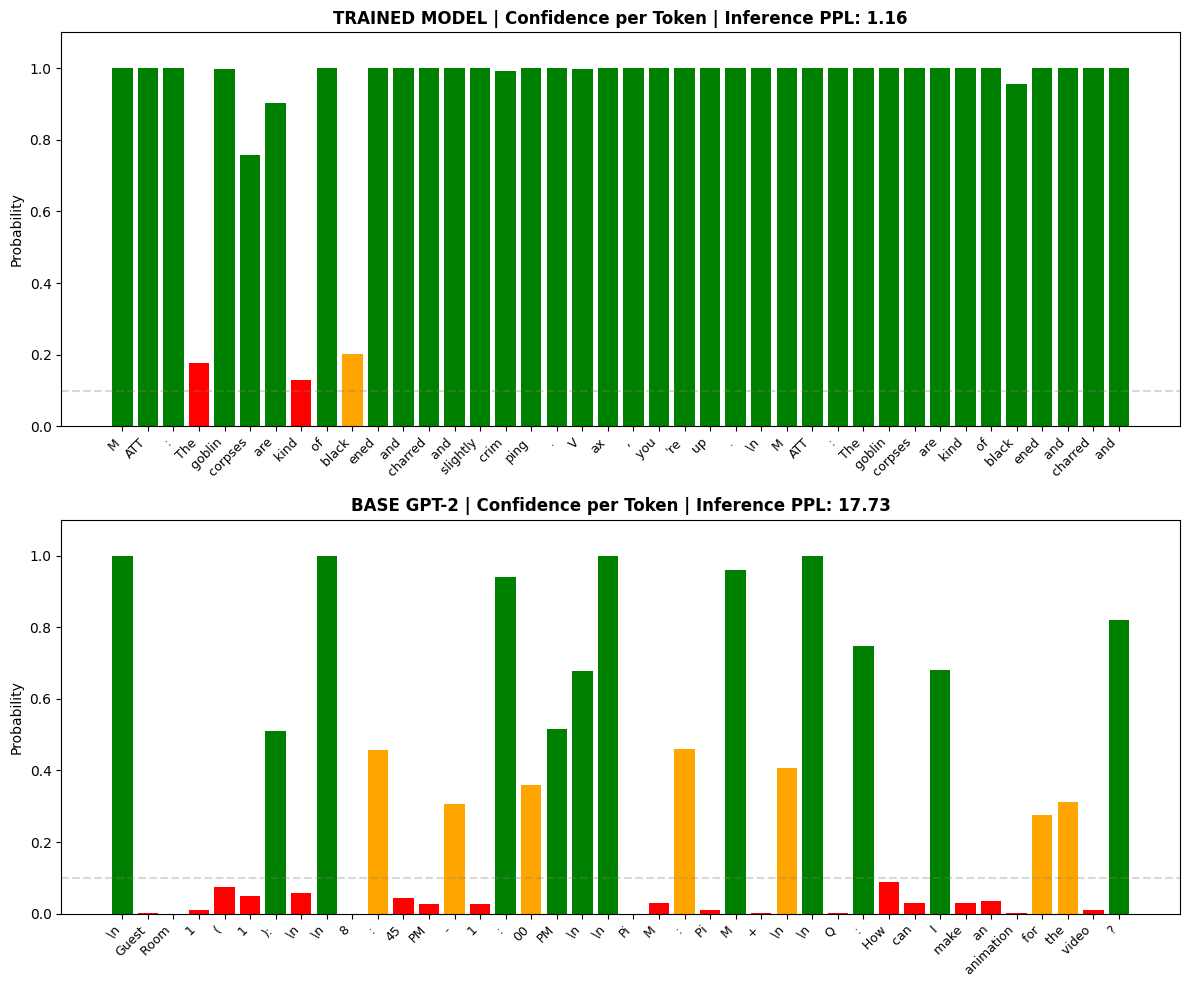

In [ ]:
# Quantitative Testing: Perplexity Baseline vs Fine-Tuned
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math

prompt = "Player: I cast Fireball at the goblin!\n"
max_new_tokens = 40
temperature = 0.8

def get_confidence_stats(model, model_name, start_prompt):
    model.eval()
    if 'encode' in globals():
        ctx_tokens = encode(start_prompt)
    else:
        enc = tiktoken.get_encoding("gpt2")
        ctx_tokens = enc.encode(start_prompt)

    context = torch.tensor(ctx_tokens, dtype=torch.long, device=device)[None, ...]

    gen_tokens = []
    gen_probs = []
    curr_ctx = context

    for _ in range(max_new_tokens):
        with torch.no_grad():
            logits, _ = model(curr_ctx)
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)

            idx_next = torch.multinomial(probs, num_samples=1)

            token_id = idx_next.item()
            chosen_prob = probs[0, token_id].item()

            if 'decode' in globals():
                token_str = decode([token_id])
            else:
                import tiktoken
                enc = tiktoken.get_encoding("gpt2")
                token_str = enc.decode([token_id])

            gen_tokens.append(token_str)
            gen_probs.append(chosen_prob)

            curr_ctx = torch.cat((curr_ctx, idx_next), dim=1)

    # Calculate Perplexity
    log_probs = [math.log(p) for p in gen_probs]
    avg_neg_log_prob = -sum(log_probs) / len(log_probs)
    ppl = math.exp(avg_neg_log_prob)

    return {
        'name': model_name,
        'text': "".join(gen_tokens),
        'tokens': gen_tokens,
        'probs': gen_probs,
        'ppl': ppl
    }


print(f"Generating from: '{prompt}'\n")
stats_trained = get_confidence_stats(model_trained, "TRAINED MODEL", prompt)
stats_base = get_confidence_stats(model_base, "BASE GPT-2", prompt)

print(f"--- {stats_trained['name']} (PPL: {stats_trained['ppl']:.2f}) ---")
print(f"OUTPUT: {stats_trained['text']}")
print("\n" + "-"*40 + "\n")
print(f"--- {stats_base['name']} (PPL: {stats_base['ppl']:.2f}) ---")
print(f"OUTPUT: {stats_base['text']}")
print("\n" + "="*40 + "\n")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

def plot_bars(ax, stats):
    x = range(len(stats['tokens']))
    colors = ['green' if p > 0.5 else 'orange' if p > 0.2 else 'red' for p in stats['probs']]
    ax.bar(x, stats['probs'], color=colors)
    ax.set_title(f"{stats['name']} | Confidence per Token | Inference PPL: {stats['ppl']:.2f}", fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1.1)
    ax.set_ylabel("Probability")
    labels = [t.replace('\n', '\\n') for t in stats['tokens']]
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
    ax.axhline(y=0.1, color='gray', linestyle='--', alpha=0.3)

plot_bars(ax1, stats_trained)
plot_bars(ax2, stats_base)

plt.tight_layout()
plt.show()

In [ ]:
import torch
import json
import difflib
import tiktoken

spell_database = [
    {
        "name": "Fireball",
        "level": "3rd-level evocation",
        "desc": "A bright streak flashes from your pointing finger to a point you choose within range and then blossoms with a low roar into an explosion of flame. Each creature in a 20-foot-radius sphere centered on that point must make a Dexterity saving throw. A target takes 8d6 fire damage on a failed save, or half as much damage on a successful one."
    },
    {
        "name": "Magic Missile",
        "level": "1st-level evocation",
        "desc": "You create three glowing darts of magical force. Each dart hits a creature of your choice that you can see within range. A dart deals 1d4 + 1 force damage to its target. The darts all strike simultaneously, and you can direct them to hit one creature or several."
    }
]

spell_book = {}
for s in spell_database:
    name = s['name'].lower()
    desc = f"SPELL: {s['name']}\nLEVEL: {s['level']}\nDESC: {s['desc']}"
    spell_book[name] = desc

print(f"Loaded Knowledge Base with {len(spell_book)} Critical Spells.")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_rule_context(user_prompt):
    user_prompt = user_prompt.lower()
    found_rules = []

    for spell_name in spell_book.keys():
        if spell_name in user_prompt:
            found_rules.append(spell_book[spell_name])

    if not found_rules:
        return None
    return found_rules[0]

def generate_response(model, prompt, use_rag=False, max_tokens=80):
    model.eval()

    final_prompt = prompt

    if use_rag:
        rule_text = get_rule_context(prompt)
        if rule_text:
            final_prompt = f"Reference Rule:\n{rule_text}\n\nSTORY START\n{prompt}"
            print(f"RAG ACTIVATED: Injected rule for '{rule_text.splitlines()[0]}'")
        else:
            print("RAG FAILED: No relevant rule found in prompt.")

    if 'encode' in globals():
        encode_fn = globals()['encode']
        decode_fn = globals()['decode']
    else:
        enc = tiktoken.get_encoding("gpt2")
        encode_fn = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
        decode_fn = lambda l: enc.decode(l)

    context = torch.tensor(encode_fn(final_prompt), dtype=torch.long, device=device)[None, ...]

    with torch.no_grad():
        y = model.generate(context, max_new_tokens=max_tokens, temperature=0.7)
        output_full = decode_fn(y[0].tolist())

    if "STORY START" in output_full:
        response_only = output_full.split(prompt)[-1]
    else:
        response_only = output_full[len(final_prompt):]

    return response_only.strip()

test_prompt = "Player: I cast Magic Missile at the goblins!\nDM:"
num_samples = 3
target_length = 40

print("\n" + "="*50)
print("TEST 1: FINE-TUNED ONLY (Memory Only)")
print("="*50)
for k in range(num_samples):
    res_norag = generate_response(model_trained, test_prompt, use_rag=False, max_tokens=target_length)
    print(f"Sample {k+1}:\n{res_norag}\n")

print("\n" + "="*50)
print("TEST 2: FINE-TUNED + RAG (Rulebook Injected)")
print("="*50)
for k in range(num_samples):
    res_rag = generate_response(model_trained, test_prompt, use_rag=True, max_tokens=target_length)
    print(f"Sample {k+1}:\n{res_rag}\n")

Loaded Knowledge Base with 2 Critical Spells.

TEST 1: FINE-TUNED ONLY (Memory Only)
Sample 1:
The goblins are doing a sincere amount of damage. None of them are Sneak Attack, unfortunately.
MATT: The goblins are doing a sincere amount of damage. None of them are Sneak Attack,

Sample 2:
The goblins are doing their nothing, they're kind of pacing behind the main platform.
MATT: The goblins are doing their nothing, they're kind of pacing behind the main platform.
M

Sample 3:
The goblins are what you roll?
MATT: The magic spell disappeared.
MATT: The magic spell disappeared.
MATT: The magic spell disappeared. All right. So the top


TEST 2: FINE-TUNED + RAG (Rulebook Injected)
RAG ACTIVATED: Injected rule for 'SPELL: Magic Missile'
Sample 1:
Okay.
MATT: Okay, so you fire one beam off and it slams into the side of one of the goblins and (imitates explosion) across the way. The ooze just

RAG ACTIVATED: Injected rule for 'SPELL: Magic Missile'
Sample 2:
Okay.
MATT: Okay, so they (whoosh) 

In [60]:
import torch
import tiktoken

spell_database = [
    {
        "name": "Fireball",
        "level": "3rd-level evocation",
        "desc": "A bright streak flashes from your pointing finger to a point you choose within range and then blossoms with a low roar into an explosion of flame. Each creature in a 20-foot-radius sphere centered on that point must make a Dexterity saving throw. A target takes 8d6 fire damage on a failed save, or half as much damage on a successful one."
    },
    {
        "name": "Magic Missile",
        "level": "1st-level evocation",
        "desc": "You create three glowing darts of magical force. Each dart hits a creature of your choice that you can see within range. A dart deals 1d4 + 1 force damage to its target. The darts all strike simultaneously, and you can direct them to hit one creature or several."
    }
]

spell_book = {}
for s in spell_database:
    name = s['name'].lower()
    desc = f"SPELL: {s['name']}\nLEVEL: {s['level']}\nDESC: {s['desc']}"
    spell_book[name] = desc

# Ensure models are loaded
if 'model_base' not in globals() or 'model_trained' not in globals():
    raise NameError("Models not found. Please run the model loading cell first.")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_rule_context(user_prompt):
    user_prompt = user_prompt.lower()
    found_rules = []
    for spell_name in spell_book.keys():
        if spell_name in user_prompt:
            found_rules.append(spell_book[spell_name])
    return found_rules[0] if found_rules else None

if 'encode' not in globals():
    enc = tiktoken.get_encoding("gpt2")
    encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
    decode = lambda l: enc.decode(l)

def generate_response(model, prompt, use_rag=False, max_tokens=40):
    model.eval()
    final_prompt = prompt

    if use_rag:
        rule_text = get_rule_context(prompt)
        if rule_text:
            final_prompt = f"Reference Rule:\n{rule_text}\n\nSTORY START\n{prompt}"

    input_ids = torch.tensor(encode(final_prompt), dtype=torch.long, device=device)[None, ...]

    with torch.no_grad():
        y = model.generate(input_ids, max_new_tokens=max_tokens, temperature=0.7)
        output_full = decode(y[0].tolist())

    if "STORY START" in output_full:
        return output_full.split(prompt)[-1].strip()
    else:
        return output_full[len(final_prompt):].strip()

prompt = "Player: I cast Magic Missile at the goblins!\nDM:"
target_count = 10
max_tokens = 40

print(f"Generating {target_count} samples per model...\n")

print("="*20 + " BASE UNTUNED GPT-2 RESPONSES " + "="*20)
for i in range(target_count):
    res = generate_response(model_base, prompt, use_rag=False, max_tokens=max_tokens)
    print(f"Sample {i+1}: {res}\n")

print("\n" + "="*20 + " FINE-TUNED + RAG RESPONSES " + "="*20)
for i in range(target_count):
    res = generate_response(model_trained, prompt, use_rag=True, max_tokens=max_tokens)
    print(f"Sample {i+1}: {res}\n")

Generating 10 samples per model...

==================== BASE UNTUNED GPT-2 RESPONSES ====================
Sample 1: I cast Magic Missile at the goblins.
DM: I cast Magic Missile at the goblins.
DM: I cast Magic Missile at the goblins.
DM: I cast Magic Missile at the goblins

Sample 2: Huh?
DM: Oh no!
DM: So I cast Magic Missile?
DM: I cast Spell Power!
DM: Ah, that's a good one.
DM: I

Sample 3: So, in the end, you cast the spell before you cast the spell?

DM: I cast the spell.

DM: (gives me a sickening smile) It was

Sample 4: You block them?
I: Yes!
DM: Thank you, Mr. Smith. Please keep me happy.
He's not allowed to communicate with the goblins.
I am the master

Sample 5: Yes! I made them stronger!
W: Yes!
DM: Yes!
W: Yes!
W: Yes!
DM: Yes!
W: Yes!
DM:

Sample 6: The goblins were surprised! They were only about 18!
DM: The goblins had no reason to be surprised!
DM: I cast Magic Missile at the goblins!
DM: The goblins looked

Sample 7: I cast a spell on you!
RNG: I cast a spell on y

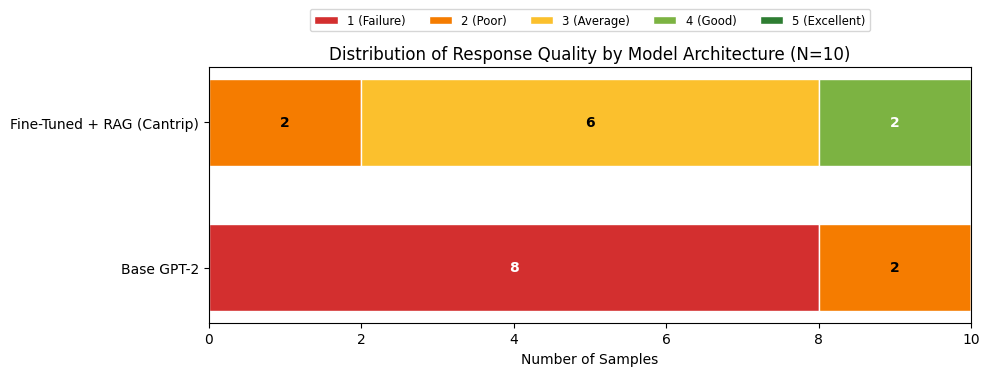

In [62]:
import matplotlib.pyplot as plt
import numpy as np


data = {
    'Base GPT-2':           [8, 2, 0, 0, 0],   # Mean: 1.2
    'Fine-Tuned + RAG (Cantrip)':     [0, 2, 6, 2, 0]    # Mean: 3.0
}

labels = list(data.keys())
results = np.array(list(data.values()))
category_names = ['1 (Failure)', '2 (Poor)', '3 (Average)', '4 (Good)', '5 (Excellent)']
category_colors = ['#d32f2f', '#f57c00', '#fbc02d', '#7cb342', '#2e7d32']

# --- PLOTTING ---
fig, ax = plt.subplots(figsize=(10, 4))

widths = results[:, 0]
starts = results.cumsum(axis=1) - results

for i, (colname, color) in enumerate(zip(category_names, category_colors)):
    widths = results[:, i]
    starts = results.cumsum(axis=1)[:, i] - widths

    ax.barh(labels, widths, left=starts, height=0.6, label=colname, color=color, edgecolor='white')

    for y, (x, c) in enumerate(zip(starts + widths/2, widths)):
        if c > 0:
            text_color = 'black' if i in [1, 2] else 'white'
            ax.text(x, y, str(c), ha='center', va='center', color=text_color, fontweight='bold')

ax.legend(ncol=5, bbox_to_anchor=(0.5, 1.25), loc='upper center', fontsize='small')
ax.set_xlabel('Number of Samples')
ax.set_title('Distribution of Response Quality by Model Architecture (N=10)')
ax.set_xlim(0, 10)

plt.tight_layout()
plt.show()

In [64]:
"""
from google.colab import files
source = 'out-crd3-masked/ckpt.pt'
destination = '/content/drive/MyDrive/dnd_model_ckpt_final.pt'

drive.mount('/content/drive')

if os.path.exists(source):
    shutil.copy(source, destination)
else:
    print(f"Failed to save model")
"""


Mounted at /content/drive
